<a href="https://colab.research.google.com/github/medha-mannem/pothole-detection/blob/main/Pothole_Detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import MobileNet
from google.colab import drive
import seaborn as sns
import tensorflow as tf

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Path to your training and testing directories
train_dir = '/content/drive/MyDrive/pimages/train'
test_dir = '/content/drive/MyDrive/pimages/test'


In [6]:
# Create training and testing sets
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 2370 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


In [7]:
# Calculate steps_per_epoch and validation_steps
train_steps_per_epoch = training_set.samples // training_set.batch_size
val_steps = test_set.samples // test_set.batch_size

In [8]:
# Define the distribution strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the model using MobileNet
    base_model = MobileNet(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
    classifier = Sequential([
        base_model,
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model with additional metrics
    classifier.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy',
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc')])

17225924/17225924 [==============================] - 0s 0us/step


In [9]:
# Check number of samples
print(f"Number of training samples: {training_set.samples}")
print(f"Number of testing samples: {test_set.samples}")

Number of training samples: 2370
Number of testing samples: 294


In [10]:
# Train the model
history = classifier.fit(
    training_set,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=test_set,
    validation_steps=val_steps
)

Epoch 1/100
74/74 [==============================] - 147s 2s/step - loss: 0.2363 - accuracy: 0.9465 - precision: 0.9708 - recall: 0.9712 - auc: 0.9204 - val_loss: 2.4308 - val_accuracy: 0.4410 - val_precision: 0.4410 - val_recall: 1.0000 - val_auc: 0.8398
Epoch 2/100
74/74 [==============================] - 23s 309ms/step - loss: 0.0786 - accuracy: 0.9756 - precision: 0.9847 - recall: 0.9888 - auc: 0.9803 - val_loss: 0.6032 - val_accuracy: 0.7153 - val_precision: 0.6058 - val_recall: 1.0000 - val_auc: 0.9840
Epoch 3/100
74/74 [==============================] - 22s 300ms/step - loss: 0.0626 - accuracy: 0.9816 - precision: 0.9889 - recall: 0.9912 - auc: 0.9842 - val_loss: 0.1631 - val_accuracy: 0.9618 - val_precision: 0.9833 - val_recall: 0.9291 - val_auc: 0.9868
Epoch 4/100
74/74 [==============================] - 22s 304ms/step - loss: 0.0671 - accuracy: 0.9752 - precision: 0.9843 - recall: 0.9888 - auc: 0.9902 - val_loss: 0.8563 - val_accuracy: 0.8160 - val_precision: 0.7088 - val_rec

In [11]:

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

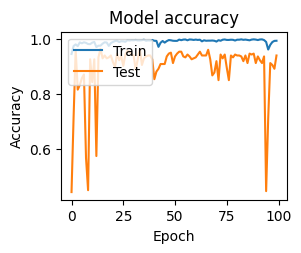

In [12]:

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

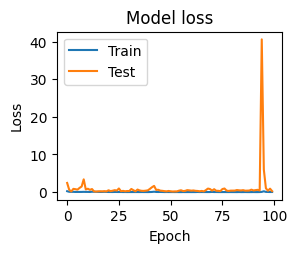

In [13]:
# Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

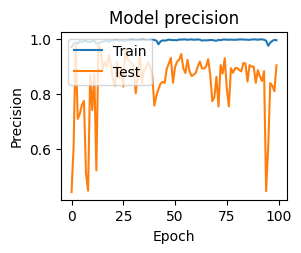

In [14]:

# Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

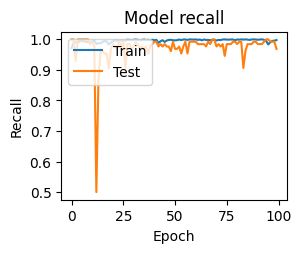

In [15]:
# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [17]:

# Function to predict image
def predictImg(imgpath):
    try:
        predict_image = load_img(imgpath, target_size=(64, 64))
        predict_image = img_to_array(predict_image)
        predict_image = np.expand_dims(predict_image, axis=0)
        result = classifier.predict(predict_image)
        return 'Pothole' if result[0][0] >= 0.5 else 'No Pothole'
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

10/10 [==============================] - 5s 395ms/step


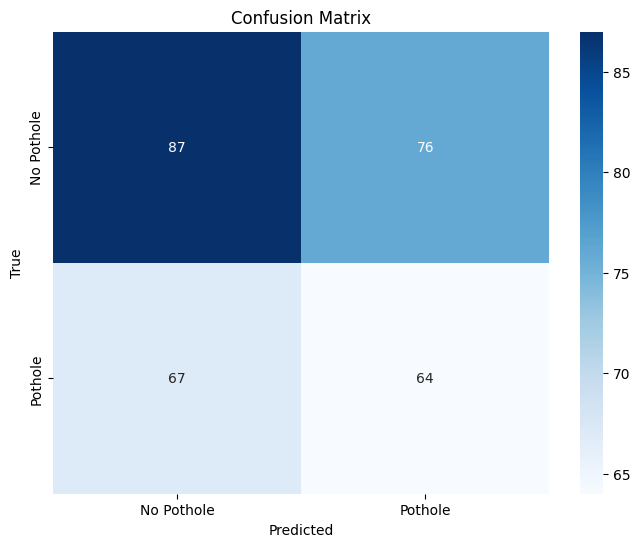

Classification Report
              precision    recall  f1-score   support

  No Pothole       0.56      0.53      0.55       163
     Pothole       0.46      0.49      0.47       131

    accuracy                           0.51       294
   macro avg       0.51      0.51      0.51       294
weighted avg       0.52      0.51      0.51       294



In [18]:
# Generate confusion matrix
def plot_confusion_matrix():
    Y_pred = classifier.predict(test_set)
    y_pred = np.round(Y_pred).astype(int)
    y_true = test_set.classes

    cm = confusion_matrix(y_true, y_pred)
    cm_plot_labels = ['No Pothole', 'Pothole']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print('Classification Report')
    target_names = ['No Pothole', 'Pothole']
    print(classification_report(y_true, y_pred, target_names=target_names))

plot_confusion_matrix()

In [24]:
print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Final Training Accuracy: 0.9948673844337463
Final Validation Accuracy: 0.9409722089767456
Final Training Loss: 0.025989828631281853
Final Validation Loss: 0.25356605648994446
